In [1]:
import numpy as np
# %matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
import seaborn as sns
import pickle
import itertools
import os
from enum import Enum, auto
from dataclasses import dataclass
sns.set()

In [2]:
colors = list(mcolors.TABLEAU_COLORS)

def setup_axis(ax, num_epochs, title, data_shape):
    ax.set_xlim(0, num_epochs - 1)
    ax.set_title(title)
    
    d = np.empty(data_shape)
    d[:] = np.nan
    data = {}
    for s in ['mean', 'std', 'max', 'min']:
        data[s] = d.copy()
    plot = []
    legend_elements = []
    for i in range(data_shape[1]):
        label = f'Layer {i}'
        mean_line = ax.plot(data['mean'][:,i], label=label, c=colors[i])[0]
        max_line = ax.plot(data['max'][:,i], c=colors[i], dashes=[6,2])[0]
        min_line = ax.plot(data['min'][:,i], c=colors[i], dashes=[6,2])[0]
        plot.append((mean_line, max_line, min_line))
        legend_elements.append(Patch(facecolor=colors[i], label=label))

    ax.legend(handles=legend_elements, loc='center right')

    
    return data, plot

def set_axis_data(ax, p, data, num_epochs, simple_avg=False):
    ax.collections.clear()

    for i, line_set in enumerate(p):
        if not simple_avg:
            for j, name in enumerate(['mean', 'max', 'min']):
                line_set[j].set_ydata(data[name][:,i])
            # ax.fill_between(range(num_epochs), data['mean'][:,i] - data['std'][:,i], data['mean'][:,i] + data['std'][:,i], color=colors[i], alpha=0.2)
        else:
            line_set[0].set_ydata(data['mean'][:,i])

    ax.relim()
    ax.autoscale()
    ax.set_xlim(0, num_epochs - 1)

In [3]:
class Mirroring(Enum):
    none = 'none'
    initial = 'initial'
    epoch = 'epoch'
    

architectures = [['simple', [32 * 32 * 3, 1024, 10]], ['simple', [32 * 32 * 3, 512, 512, 512, 10]], ['skip', [32 * 32 * 3, 10, [512]]], ['skip', [32 * 32 * 3, 10, [1024, 512]]]]

experiments = list(itertools.product(*[
    architectures,
    [['pepita', 0.01], ['fa', 0.001]],
    ['sgd', 'mom'], # update algorithms
    list(Mirroring), # mirroring
    list(range(3))]))# run number


@dataclass
class Exp:
    
    architecture: str
    layers: list
    learning_algo: str
    learning_rate: float
    update_algo: str
    mirroring: Mirroring
    exp_num: int
    
    def __post_init__(self):
        self.exp_dir = f'/home/cpsc490_ac2788/CPSC490/experiments/set2/exp{self.exp_num}'
        self.log = os.path.join(self.exp_dir, 'exp_parameters.txt')
            
#         self.exp_run_dir = os.path.join(self.exp_dir, f'run{self.run}')

#         self.exp_log = os.path.join(self.exp_run_dir, 'exp_parameters.txt')
#         self.exp_stat_file = os.path.join(self.exp_run_dir, 'net_statistics.pkl')
#         self.fig_file = os.path.join(self.exp_run_dir, 'fig.png')
        
    
    @classmethod
    def expi(cls, i):
        
        e = experiments[i]
        
        ret=cls(
        e[0][0],
        e[0][1],
        e[1][0],
        e[1][1],
        e[2],
        e[3],
        i // 3)
        
        return ret
    
    def __str__(self):
        return self.__repr__()

    def __repr__(self):
        out = ''
        obj_vars = vars(self)
        for k in obj_vars:
            if k == 'mirroring':
                out += f'{k} : {obj_vars[k].value}\n'
            else:
                out += f'{k} : {obj_vars[k]}\n'
        return out
    
    def log(self, path):
        with open(path, 'w') as f:
            f.write(self.__repr__())

In [4]:
exps = {}

for exp_id, e in enumerate(experiments):
        
    exp = Exp.expi(exp_id)
    exp_hash = str(exp)
    
    if exp_hash in exps:
        exp = exps[exp_hash]
    else:
        exps[exp_hash] = exp
        exp.stats = [None, None, None]
    
    try:
        with open(os.path.join(exp.exp_dir, f'run{e[-1]}', 'net_statistics.pkl'), 'rb') as f:
            exp.stats[e[-1]] = pickle.load(f)
    except:
        pass
    
exps = list(exps.values())

In [5]:
for exp in exps:
    exp.collated_stats = {}
    for stat_type in exp.stats[0]:
        all_runs = []
        for i in range(3):
            if exp.stats[i] is not None:
                all_runs.append(exp.stats[i][stat_type]['mean'])
        all_runs = np.array(all_runs)
        exp.collated_stats[stat_type] = {
        'mean': np.nanmean(all_runs, axis=0),
        'std': np.nanstd(all_runs, axis=0),
        'max': np.nanmax(all_runs, axis=0),
        'min': np.nanmin(all_runs, axis=0)
        }

/tmp/ipykernel_9764/200496194.py:10: RuntimeWarning: Mean of empty slice
  'mean': np.nanmean(all_runs, axis=0),
/gpfs/loomis/project/cpsc490/cpsc490_ac2788/conda_envs/pepita/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_9764/200496194.py:12: RuntimeWarning: All-NaN slice encountered
  'max': np.nanmax(all_runs, axis=0),
/tmp/ipykernel_9764/200496194.py:13: RuntimeWarning: All-NaN slice encountered
  'min': np.nanmin(all_runs, axis=0)


In [12]:
architecture = ['simple']
learning_algo = ['pepita']
update_algo = ['mom']
mirroring = [i.value for i in [Mirroring.initial]]
layers = [str(i) for i in [[32 * 32 * 3, 1024, 10]]]

In [20]:
exps_to_show = []

for exp in exps:
    
    if exp.architecture in architecture \
    and exp.learning_algo in learning_algo \
    and exp.update_algo in update_algo \
    and exp.exp_num == 5:
        exps_to_show.append(exp)

/tmp/ipykernel_9764/2506102227.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, 6, figsize=(30, 3))


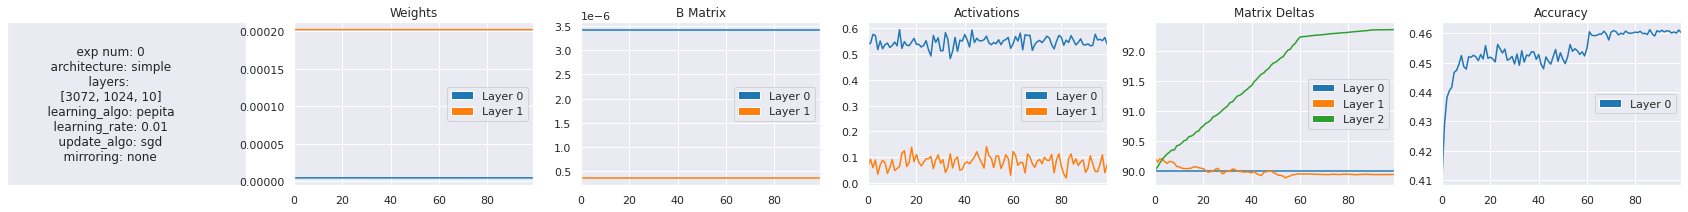

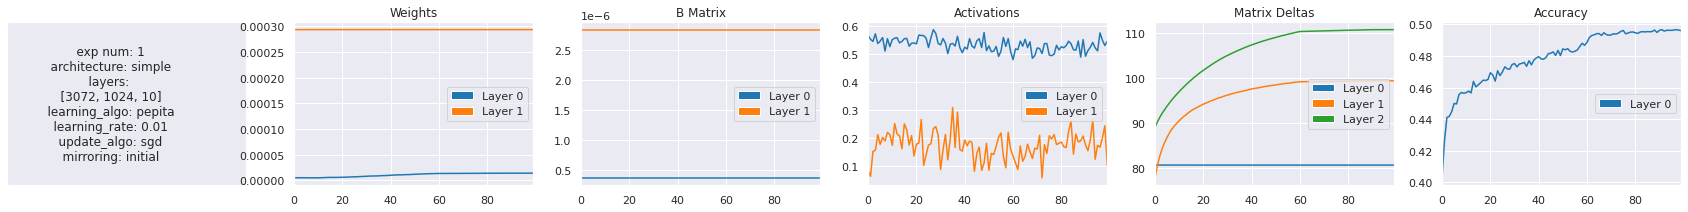

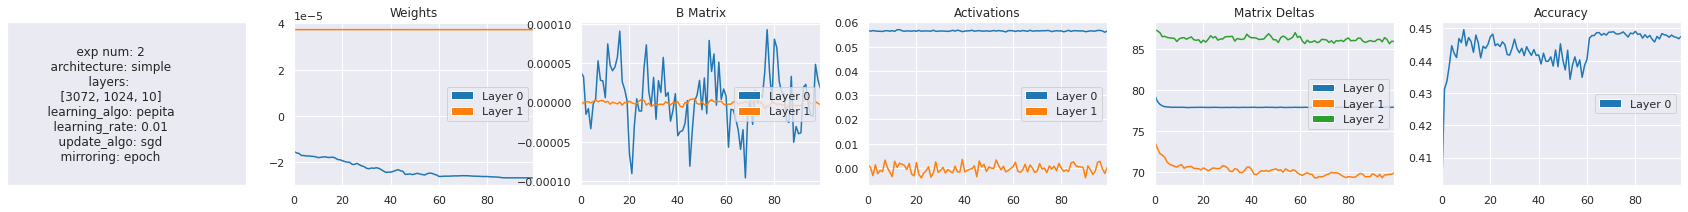

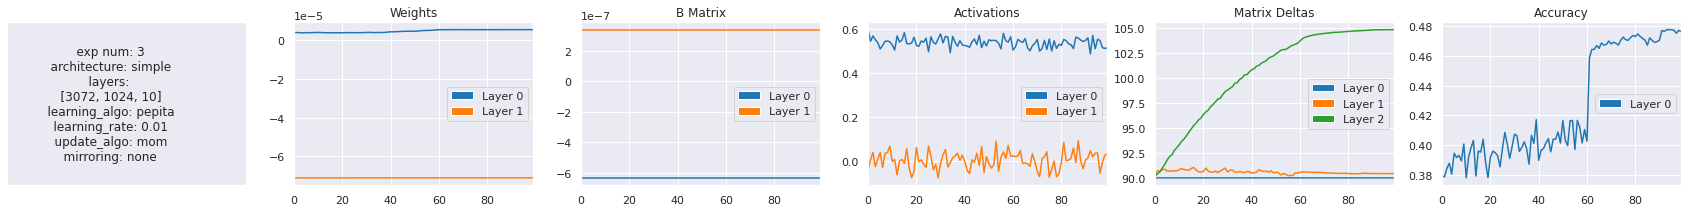

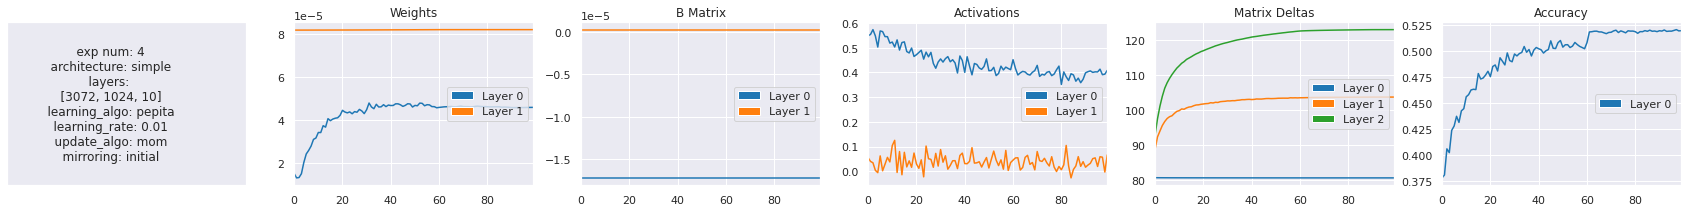

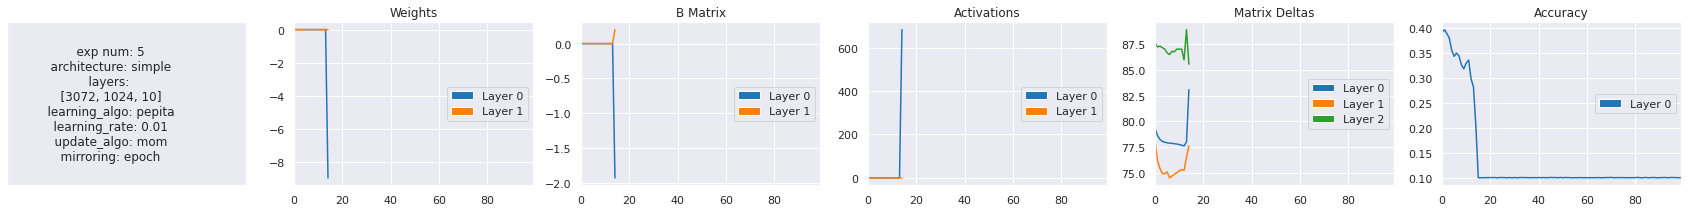

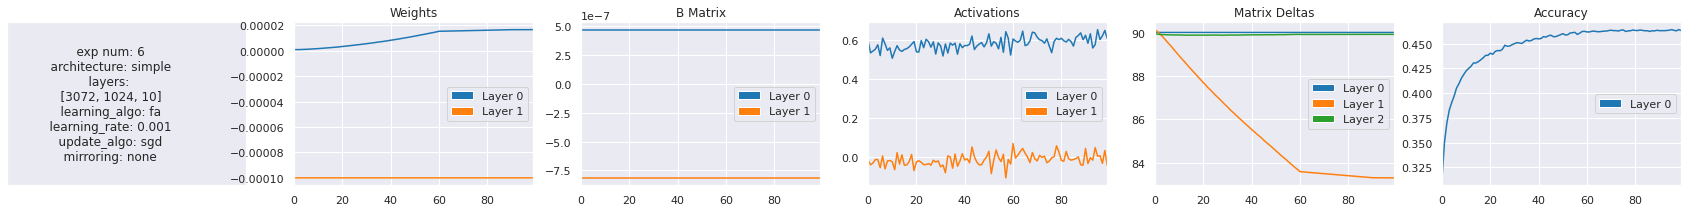

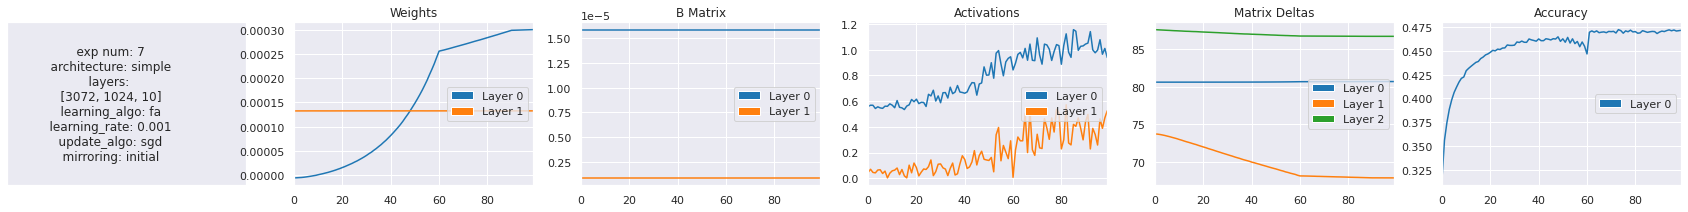

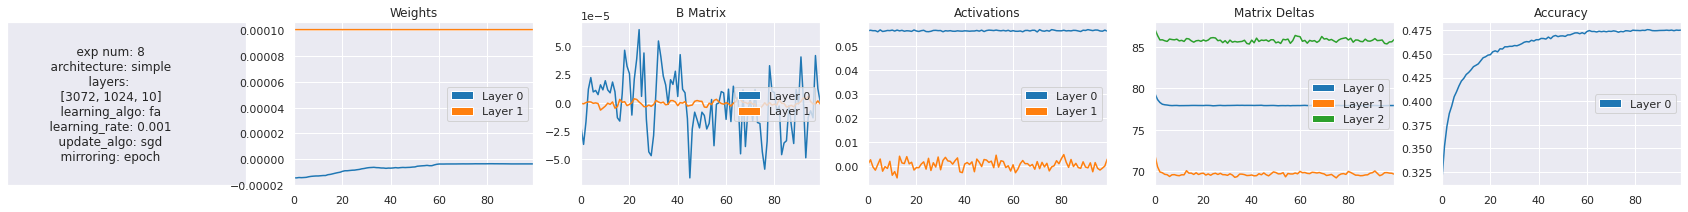

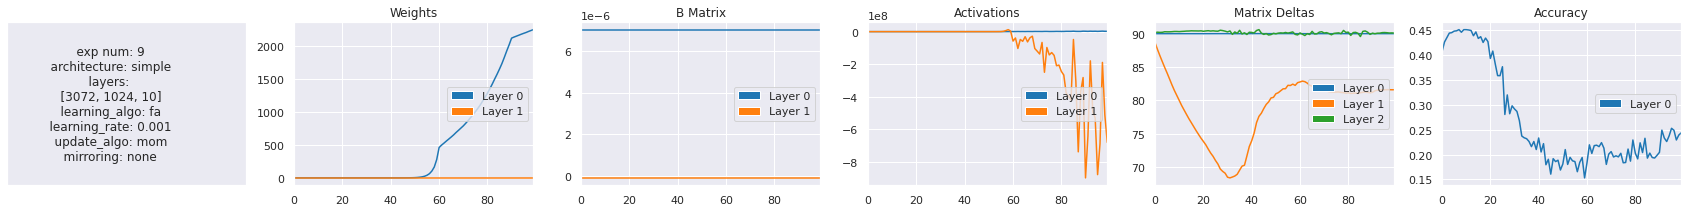

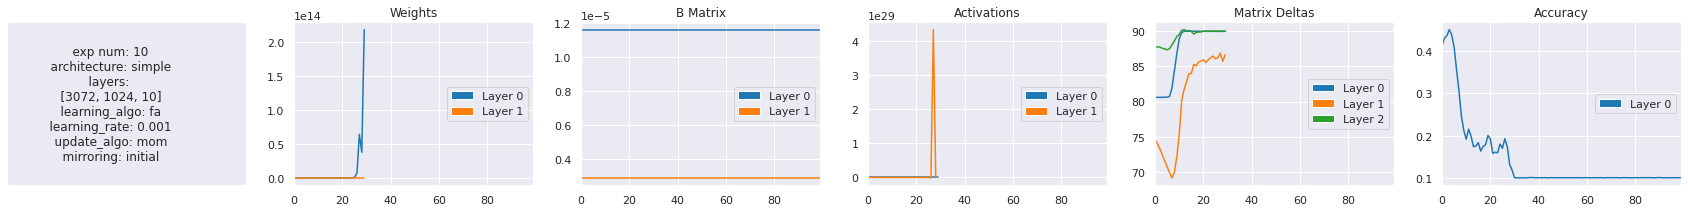

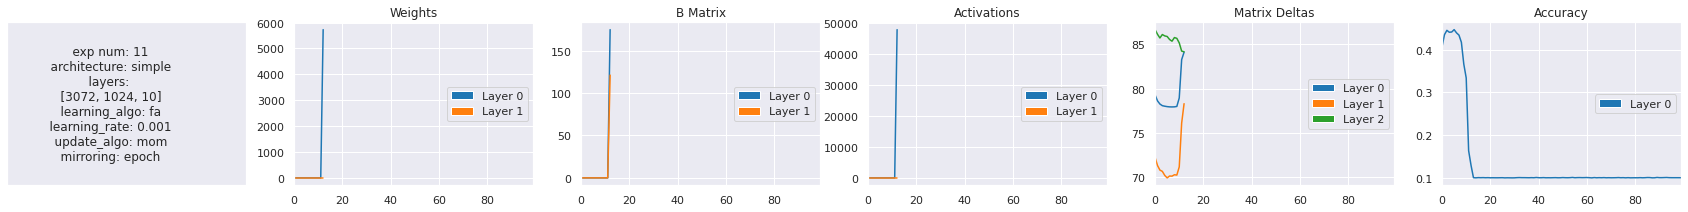

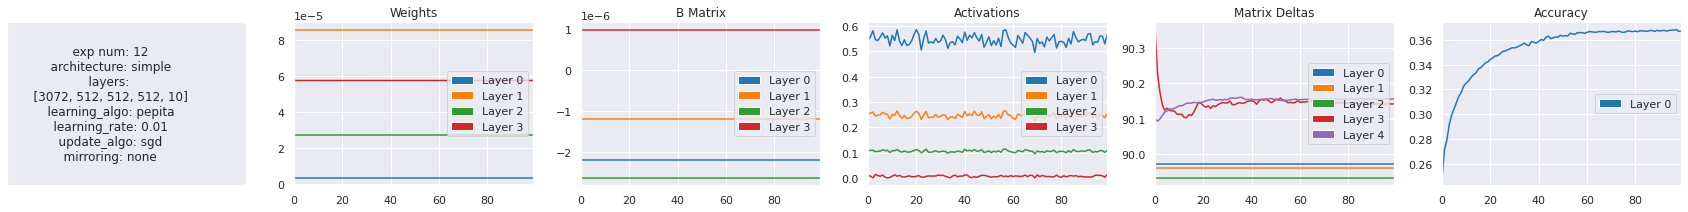

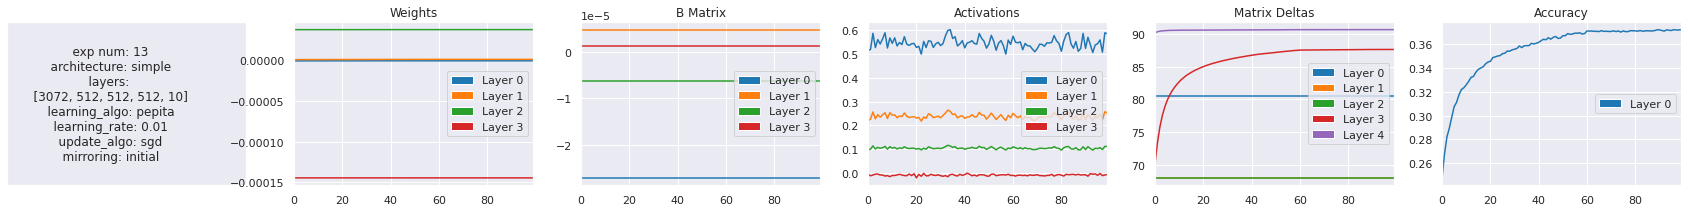

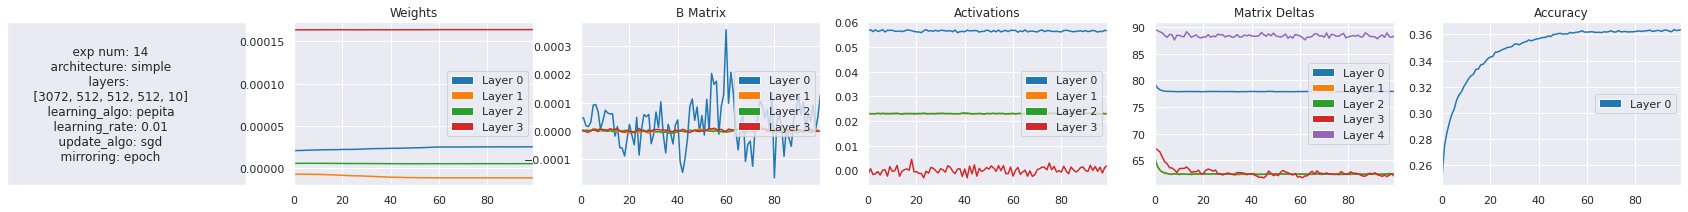

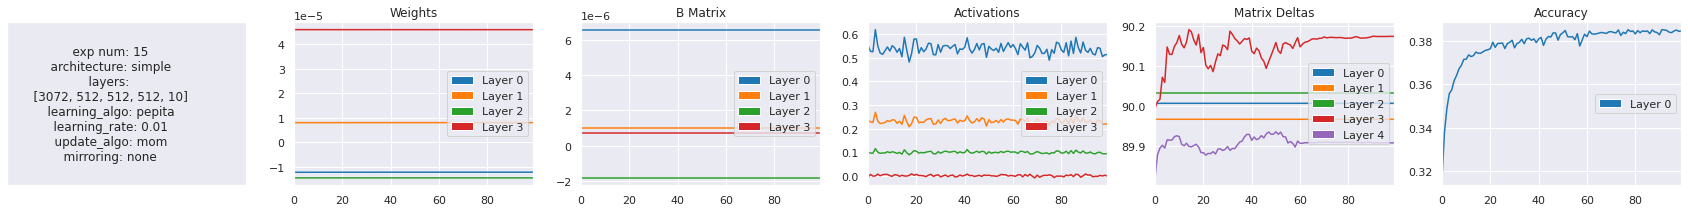

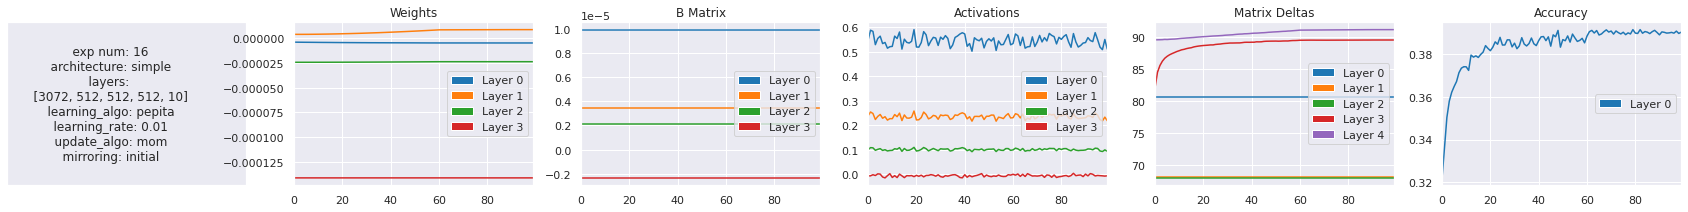

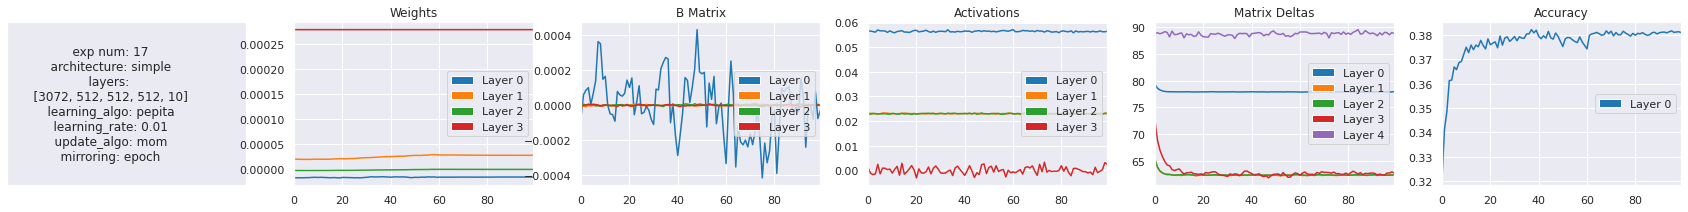

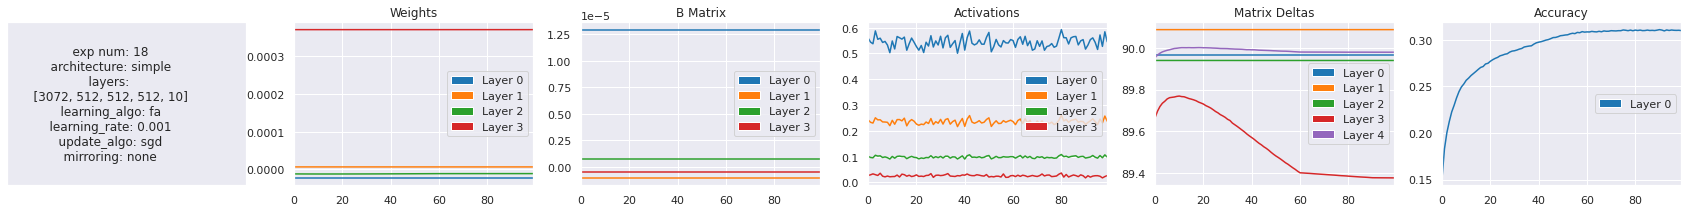

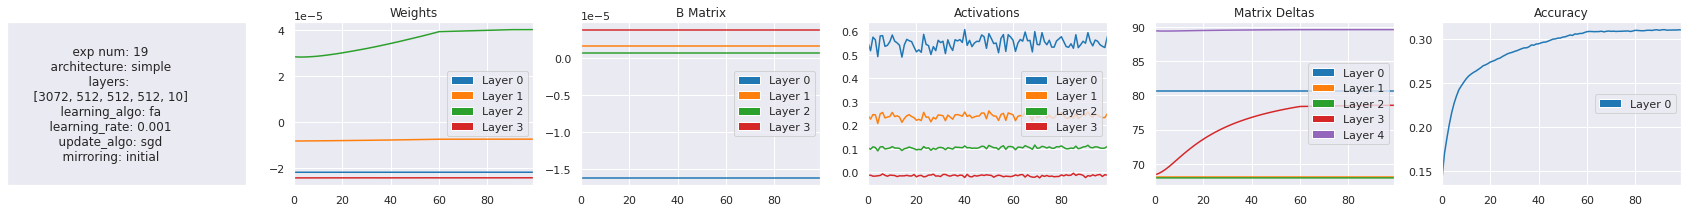

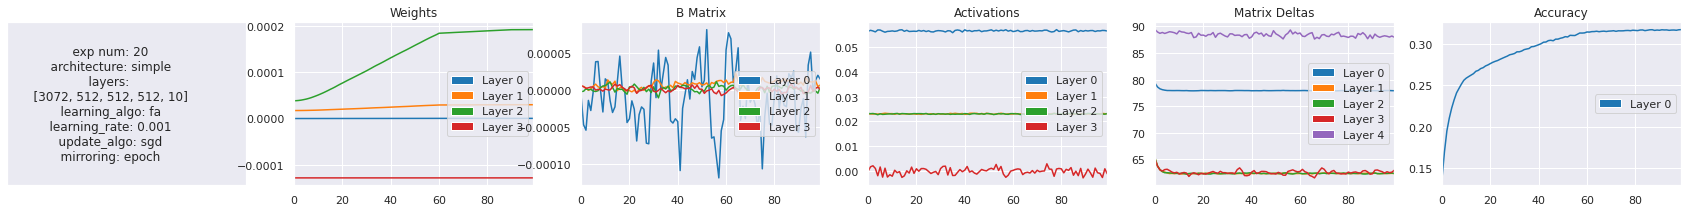

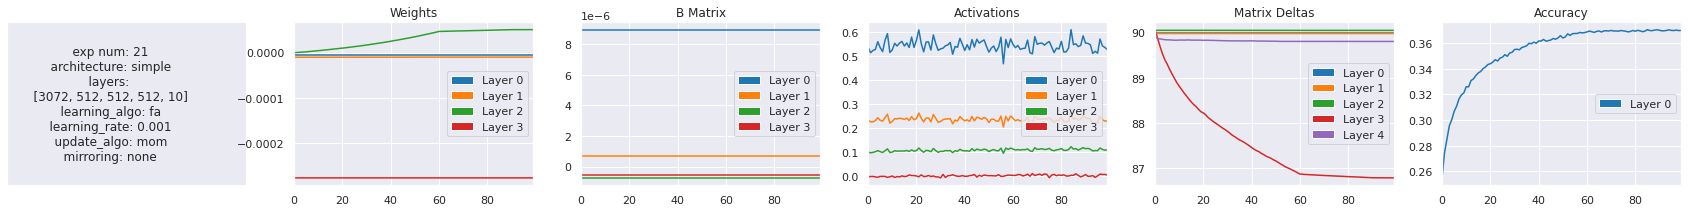

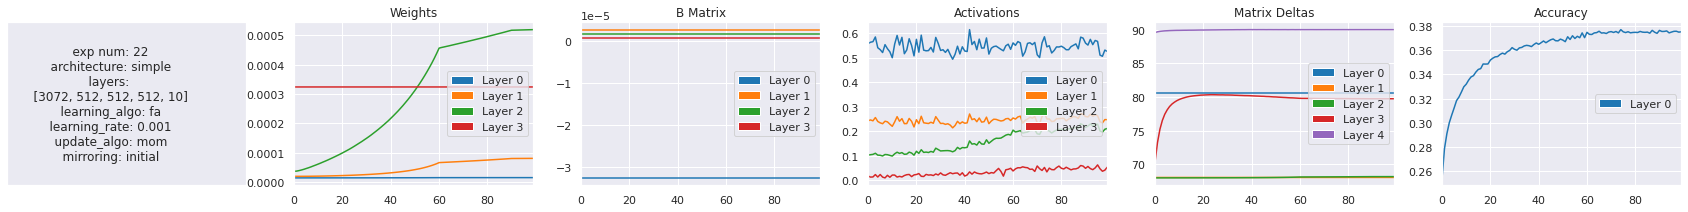

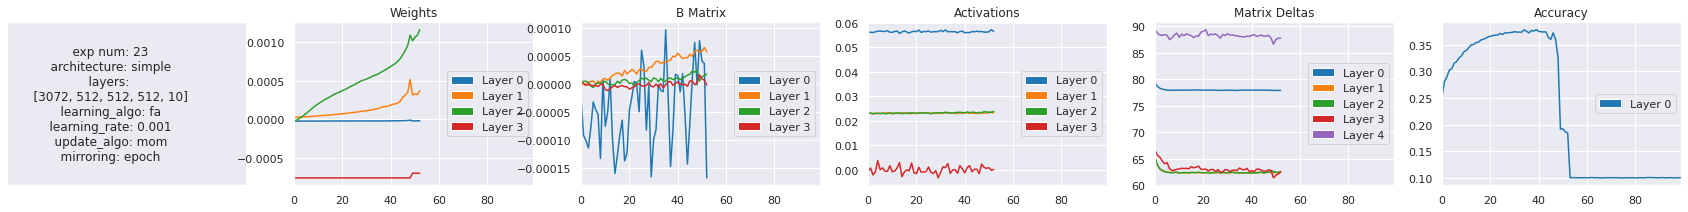

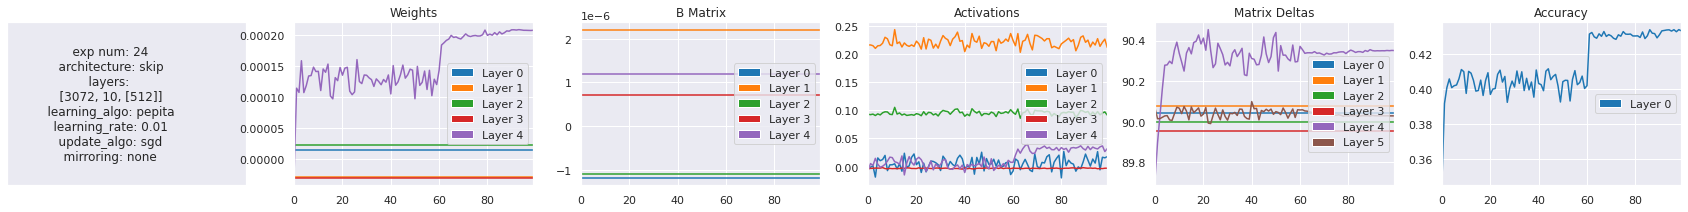

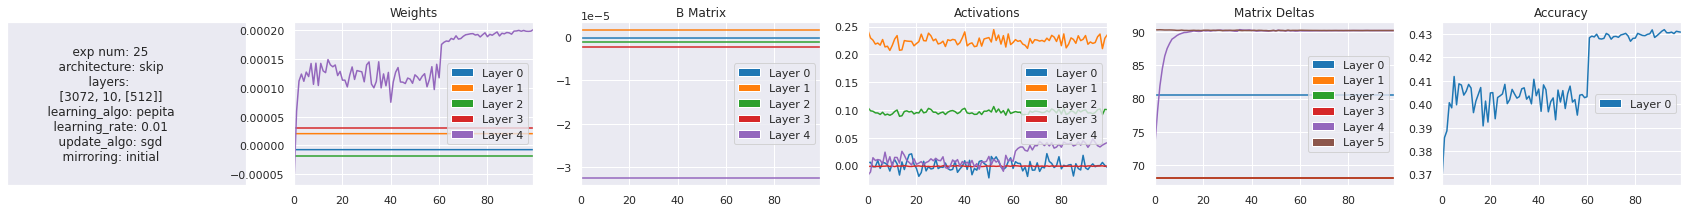

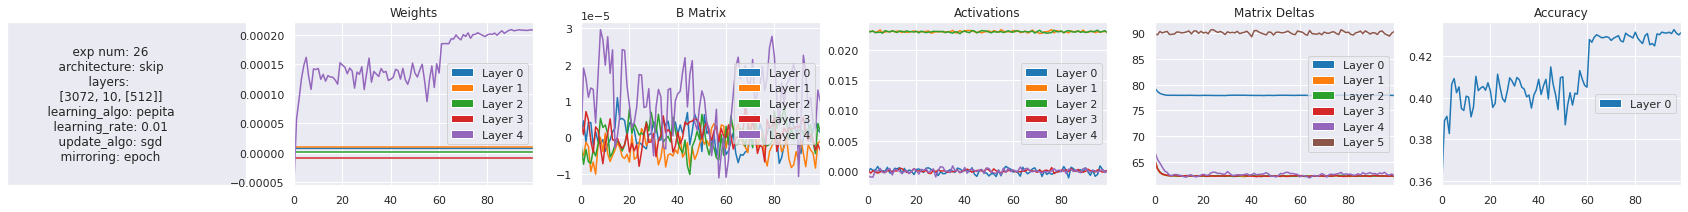

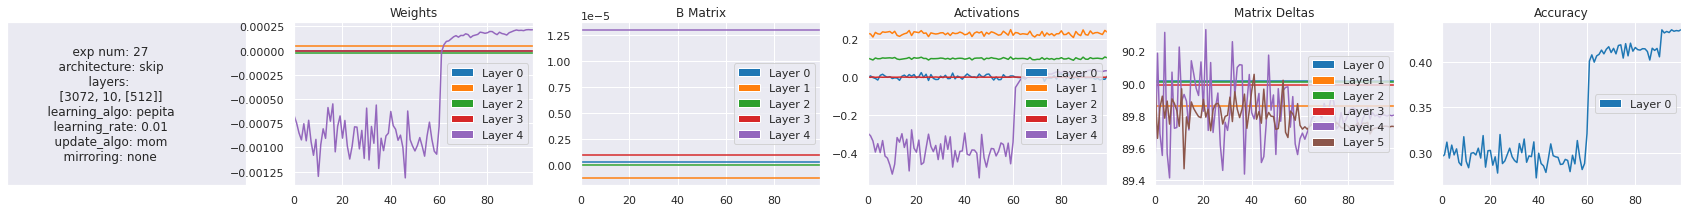

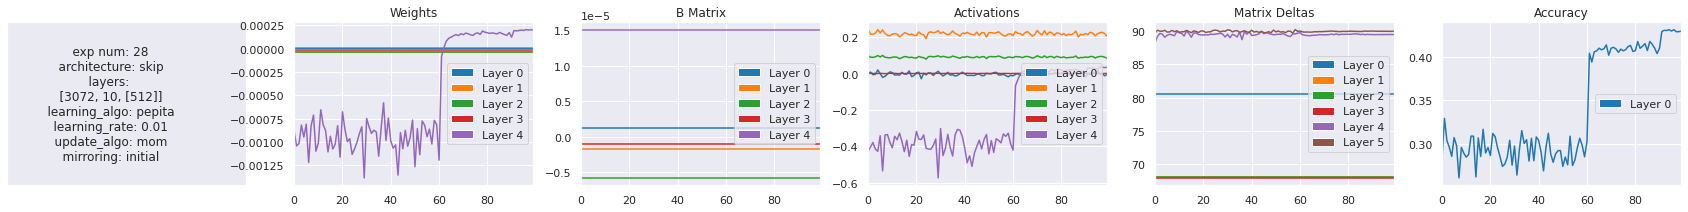

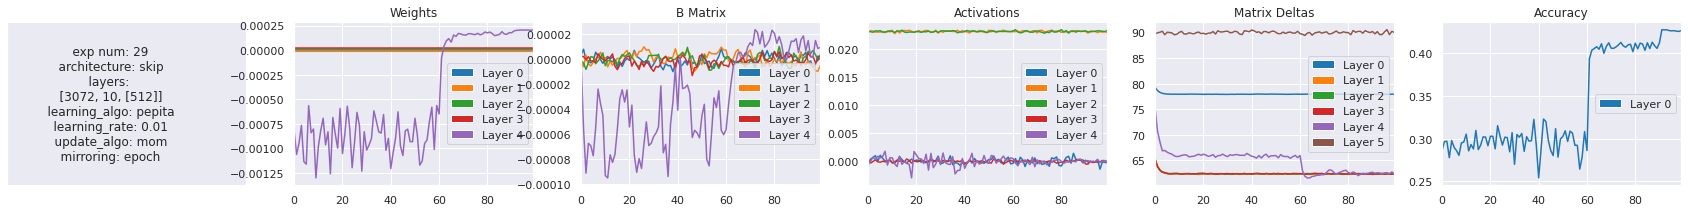

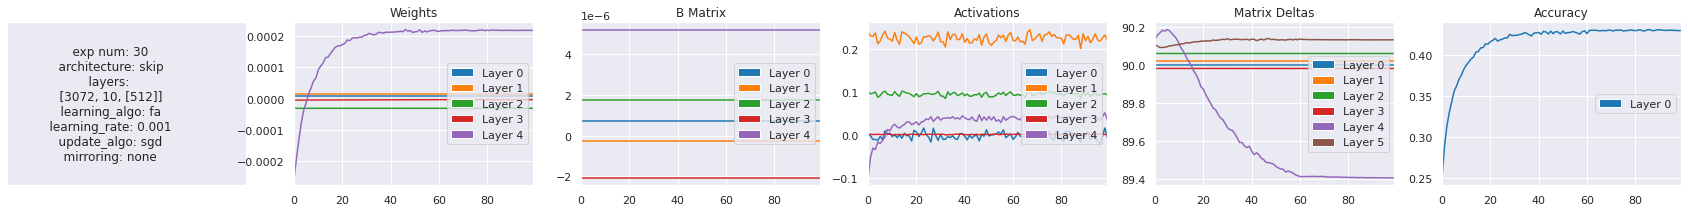

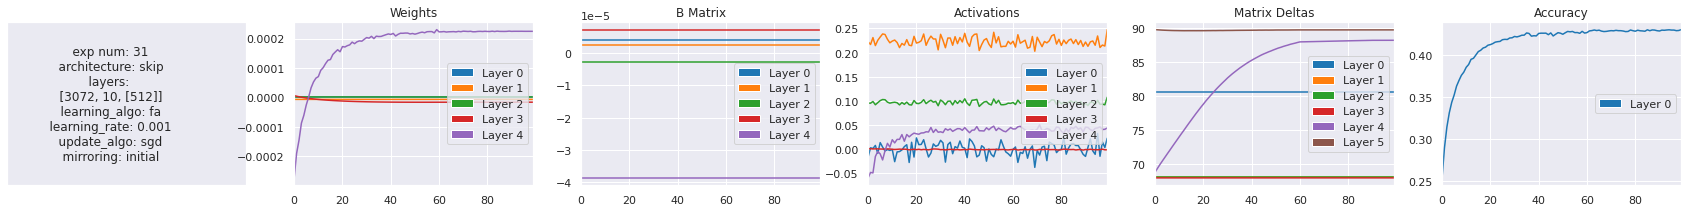

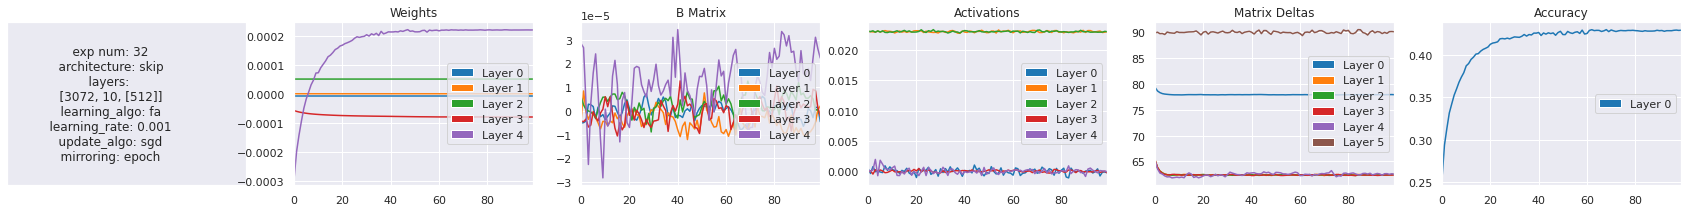

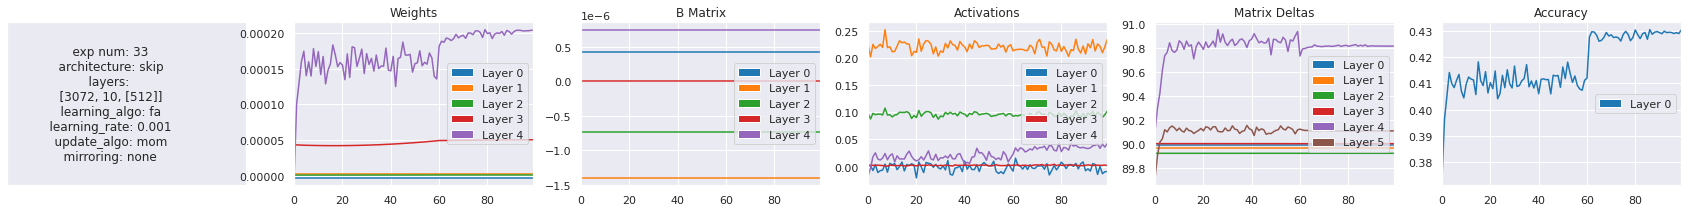

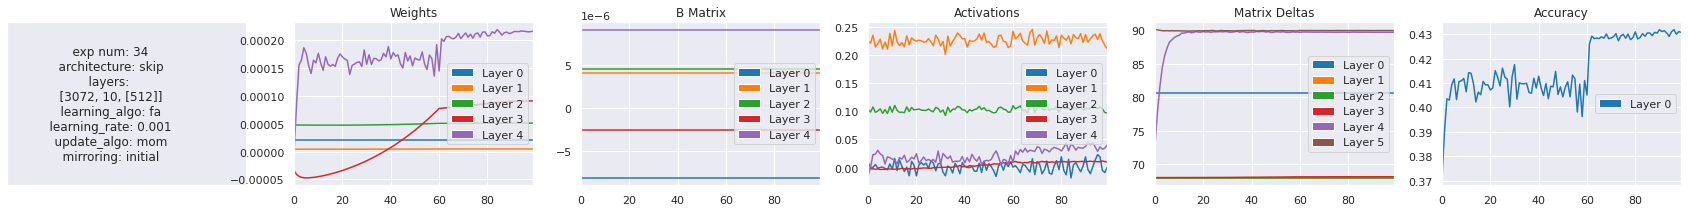

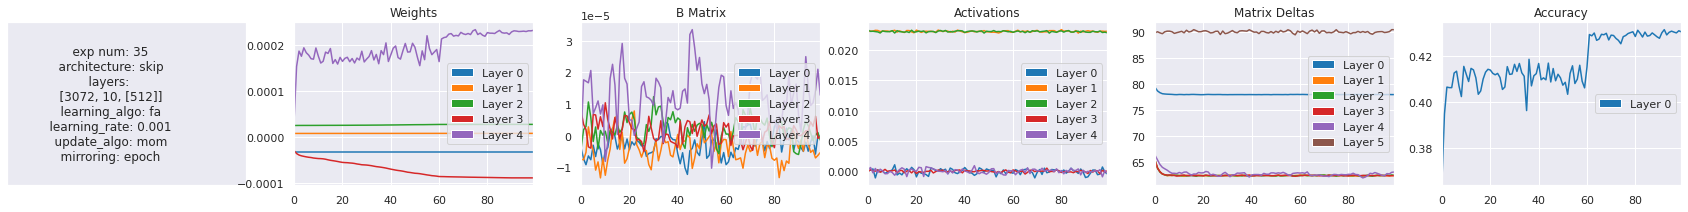

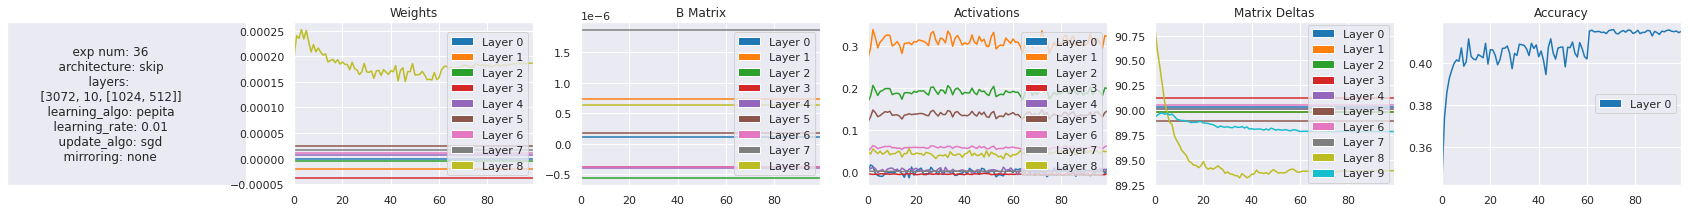

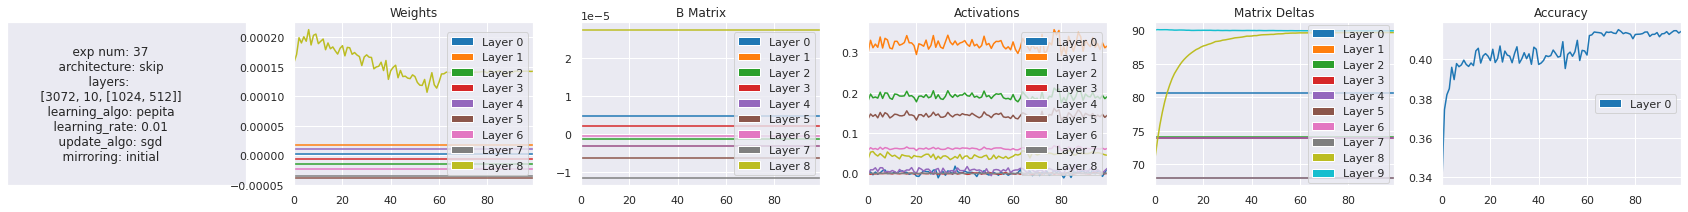

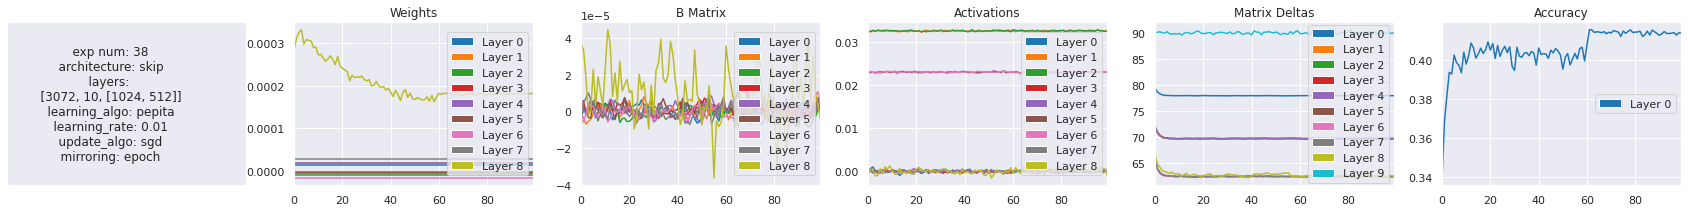

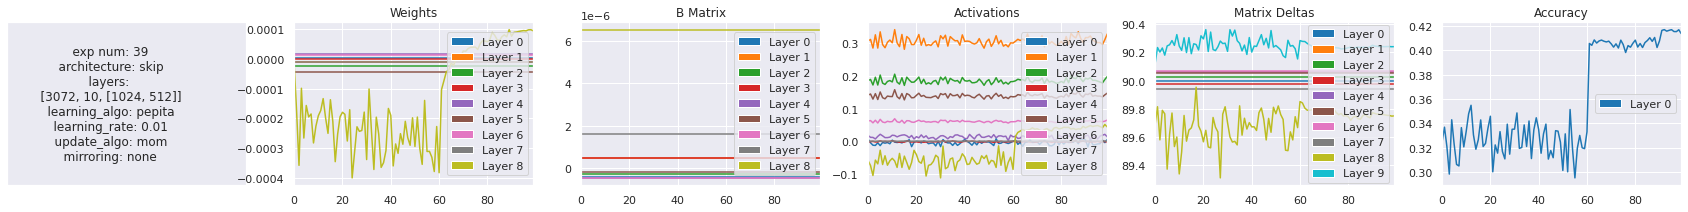

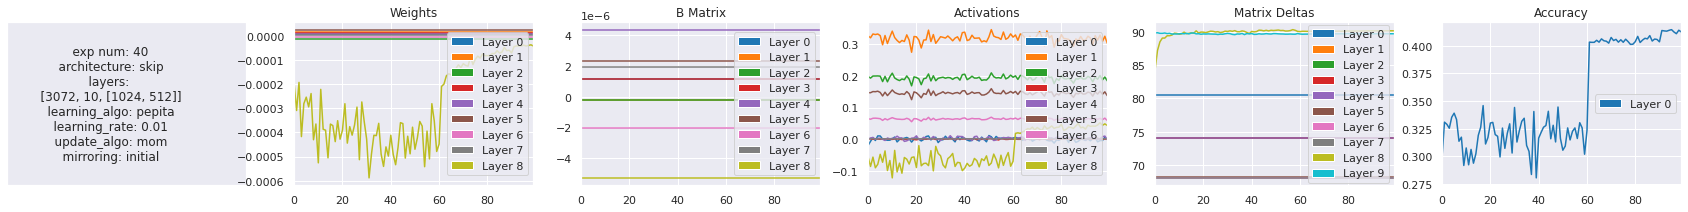

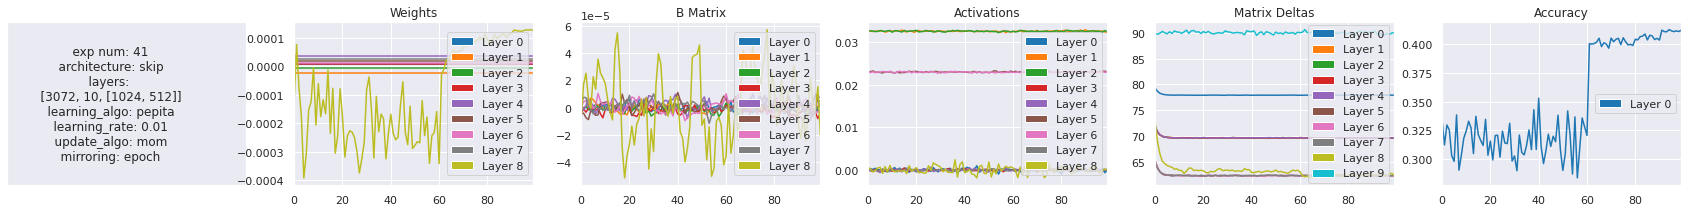

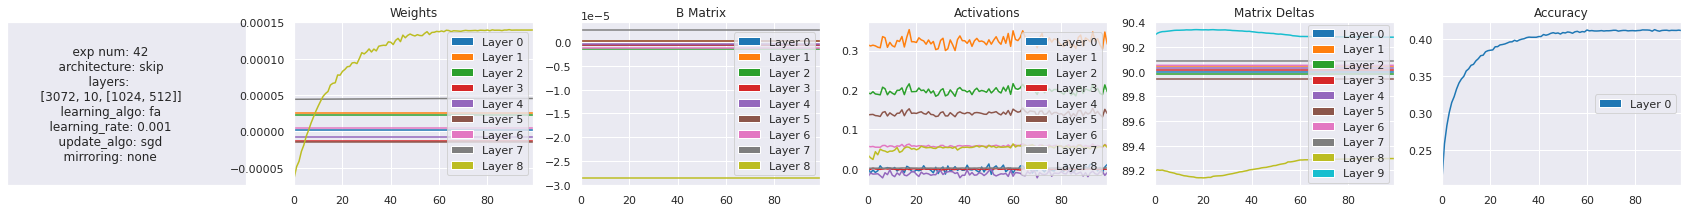

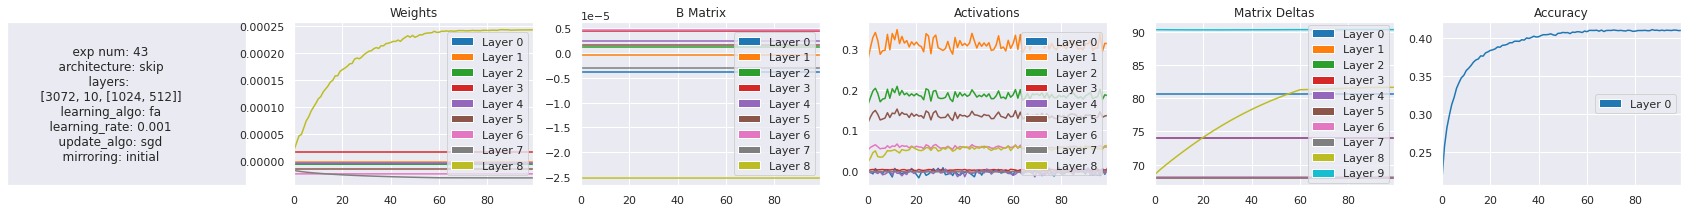

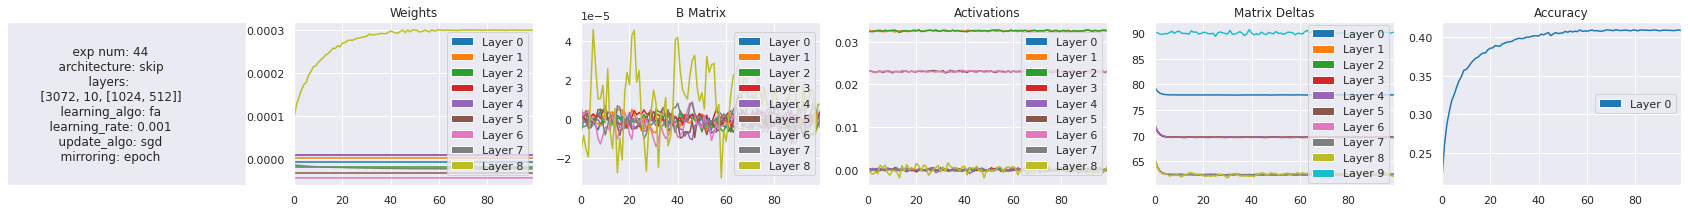

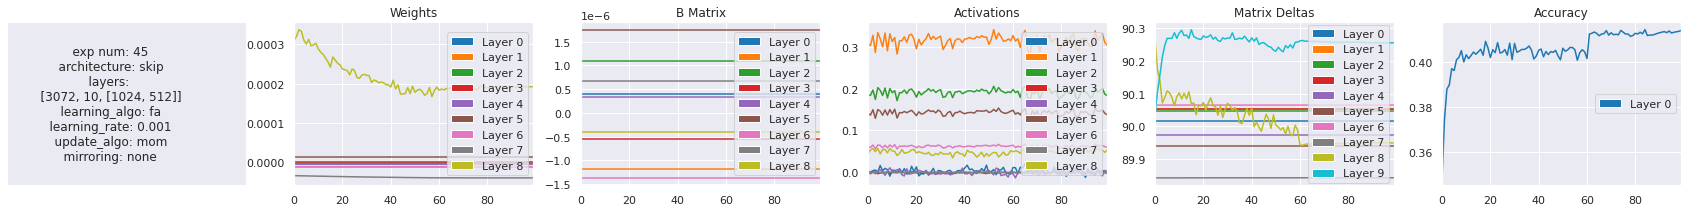

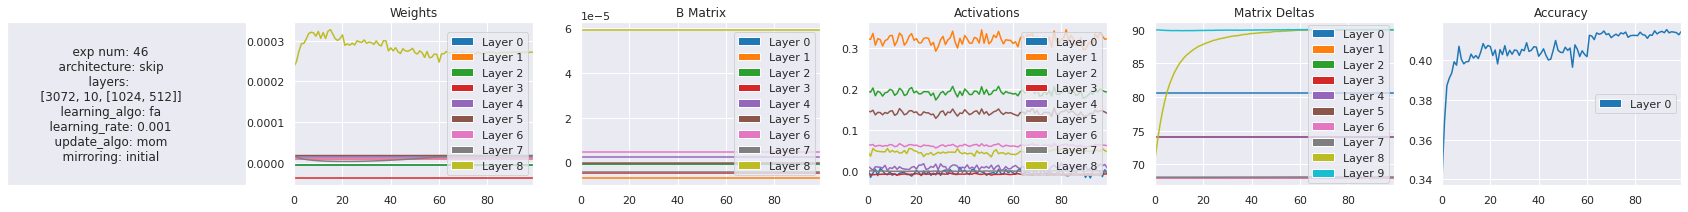

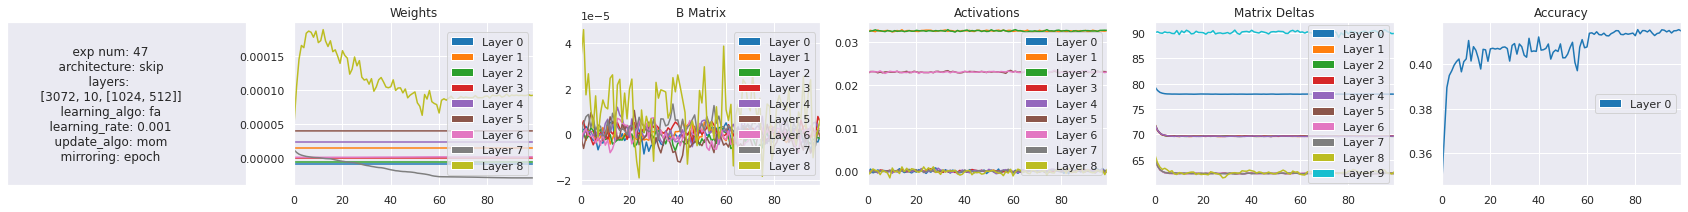

In [41]:
plt.close('all')
for exp in exps:
    
    fig, axes = plt.subplots(1, 6, figsize=(30, 3))

    exp_avg_data = exp.collated_stats
    weights = exp_avg_data['weights']
    b_weights = exp_avg_data['b_weights']
    activations = exp_avg_data['activations']
    deltas = exp_avg_data['deltas']
    accuracies = exp_avg_data['accuracies']

    _, weights_plot = setup_axis(axes[1], 200, "Weights", weights['mean'].shape)
    _, b_weights_plot = setup_axis(axes[2], 200, "B Matrix", b_weights['mean'].shape)
    _, activations_plot = setup_axis(axes[3], 200, "Activations", activations['mean'].shape)
    _, deltas_plot = setup_axis(axes[4], 200, "Matrix Deltas", deltas['mean'].shape)
    _, accuracies_plot = setup_axis(axes[5], 200, "Accuracy", accuracies['mean'].shape)

    parameters_text = f"""
    exp num: {exp.exp_num}
    architecture: {exp.architecture}
    layers: 
    {exp.layers}
    learning_algo: {exp.learning_algo}
    learning_rate: {exp.learning_rate}
    update_algo: {exp.update_algo}
    mirroring: {exp.mirroring.value}
    """
    axes[0].text(0.4, 0.5, parameters_text, ha="center", va="center")
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    set_axis_data(axes[1], weights_plot, weights, 100, simple_avg=True)
    set_axis_data(axes[2], b_weights_plot,b_weights , 100, simple_avg=True)
    set_axis_data(axes[3], activations_plot, activations, 100, simple_avg=True)
    set_axis_data(axes[4], deltas_plot, deltas, 100, simple_avg=True)
    set_axis_data(axes[5], accuracies_plot, accuracies, 100, simple_avg=True)
    
    plt.savefig(f'./all_figs/exp{exp.exp_num}.png', bbox_inches='tight')